**Video Lecutre Transcript Summarization (using Extractive summarization technique) using Pyspark**





Install required libraries

In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5c03eeef379c4c049d955157792ac58c94a5210444d5d646fb344f49a7446c6a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
pip install transformers

In [4]:
pip install spacy

In [5]:
!pip install rouge

**Import all the required libraries and start spark session**

In [6]:
from pyspark.sql import SparkSession
from transformers import pipeline, AutoTokenizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
import matplotlib.pyplot as plt
from rouge import Rouge
import numpy as np
import os

spark = SparkSession.builder \
    .appName("Text Summarization") \
    .getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


**1. Custom Summarization (using Word Frequency technique) of lecture trancript file using Dataframes**

In [7]:
#English language model from Spacy library for NLP process
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    return text.replace('SPEAKER 0', '').replace('SPEAKER 1', '').replace('UNKNOWN', '')

def custom_summarization_using_dataframe(text, max_length=300):
    paragraphs = text.split('\n\n')
    summaries = []

    for paragraph in paragraphs:
        if len(paragraph) > 5000:
            paragraph = preprocess_text(paragraph)

            doc = nlp(paragraph)
            word_freq = {}
            stop_words = list(STOP_WORDS)
            for word in doc:
                if word.text.lower() not in stop_words and word.text.lower() not in punctuation:
                    if word.text not in word_freq.keys():
                        word_freq[word.text] = 1
                    else:
                        word_freq[word.text] += 1

            max_freq = max(word_freq.values())
            word_freq = {word: (freq / max_freq) for word, freq in word_freq.items()}

            sent_tokens = [sent for sent in doc.sents]
            sent_score = {}
            for sent in sent_tokens:
                for word in sent:
                    if word.text.lower() in word_freq.keys():
                        if sent not in sent_score.keys():
                            sent_score[sent] = word_freq[word.text.lower()]
                        else:
                            sent_score[sent] += word_freq[word.text.lower()]

            summary = nlargest(n=5, iterable=sent_score, key=sent_score.get)
            final_summary_df = [word.text for word in summary]
            summaries.append(" ".join(final_summary_df))

    return '\n\n'.join(summaries)

file_path = '/content/MTHS4005 Lecture 3 - transcript.txt'
text_df = spark.read.text(file_path)


text = ' '.join(text_df.select("value").rdd.flatMap(lambda x: x).collect())

final_summary_df = custom_summarization_using_dataframe(text)
summary_file_path_df = '/content/summary_dataframe.txt'
heading = ('/content/MTHS4005 Lecture 3 - transcript').split('/')[-1] +' Summary' + '\n';

with open(summary_file_path_df, 'w') as f:
    f.write(heading)
    f.write(final_summary_df)
f"Summary file has been saved to: {summary_file_path_df}"

'Summary file has been saved to: /content/summary_dataframe.txt'

Length of the generated summary using Dataframes

In [8]:
len(final_summary_df)

1256

**2. Word Frequency Distribution for Summary generated using Dataframes**

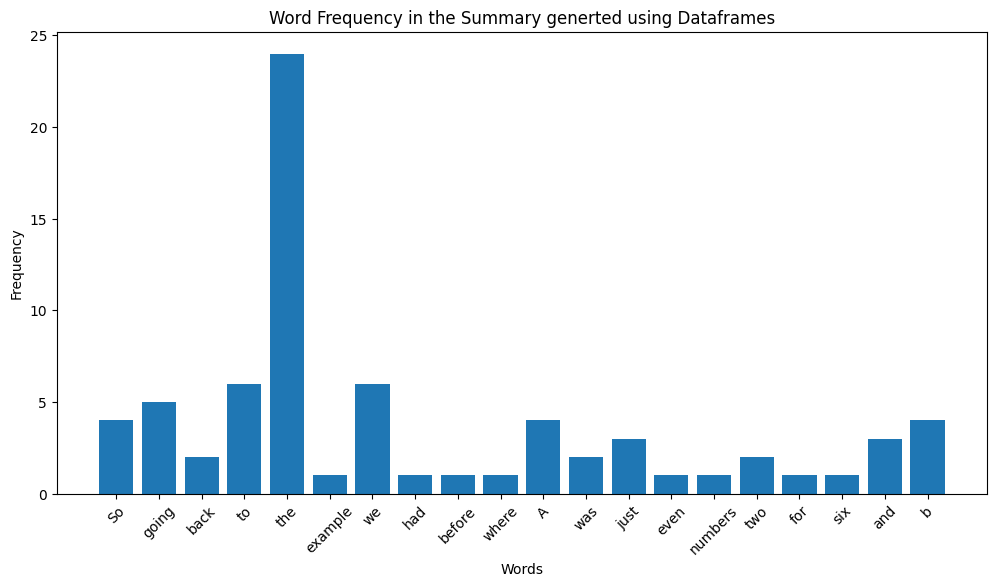

In [9]:
word_freq = {}
for word in final_summary_df.split():
    word_freq[word] = word_freq.get(word, 0) + 1
words, freqs = zip(*word_freq.items())

plt.figure(figsize=(12, 6))
plt.bar(words[:20], freqs[:20])
plt.xticks(rotation=45)
plt.title('Word Frequency in the Summary generted using Dataframes')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

**3. Evaluating the accuracy using ROUGE metric for summary generated using Dataframes**

In [10]:
def compute_rouge_scores_for_dataframes(reference, generated):
    rouge = Rouge()
    scores = rouge.get_scores(generated, reference)
    return scores

reference_summary="This week's discussion focuses on probability, introducing the mathematical background to probability and discussing its axioms. The building blocks of probability include conditional probability, independence, and random variables. Sample space, often denoted by omega, is the set of all possible outcomes of a random experiment. Experiments can be experimental designs or observations in the real world, such as stock markets. An event is a set of outcomes to which we can assign a probability, and this can be done using simple examples like throwing a die or collecting two coins. For example, if a coin throws a head, there are four possible outcomes. If a coin tosses a coin until a head appears, there are infinitely many possibilities. In mathematics, we can count these outcomes, and we can easily enumerate them. Uncountable outcomes, such as the time until a volcano next erupts, can also be used to understand probability distributions. In this case, the state space sample space is the time until something occurs, which can be positive or uncountable. The speaker emphasizes the importance of considering what is important to us when looking at random variables, such as how many heads there are. The set of possible outcomes has to be finite, and the speaker uses examples of uncountable events to illustrate the concept of probability. In conclusion, this week's discussion focuses on probability, sample space, and probability distributions. By understanding the mathematical foundations of probability and the importance of considering individual outcomes, we can better understand the complexity of probability and its applications in various fields."

rouge_scores_df = compute_rouge_scores_for_dataframes(reference_summary, final_summary_df)
print("ROUGE Scores:", rouge_scores_df)


ROUGE Scores: [{'rouge-1': {'r': 0.19424460431654678, 'p': 0.24545454545454545, 'f': 0.21686746494733966}, 'rouge-2': {'r': 0.017937219730941704, 'p': 0.022727272727272728, 'f': 0.020050120382662122}, 'rouge-l': {'r': 0.1510791366906475, 'p': 0.19090909090909092, 'f': 0.16867469386300235}}]


**4. ROGUE Scores Visualization for generated summary using Dataframes**

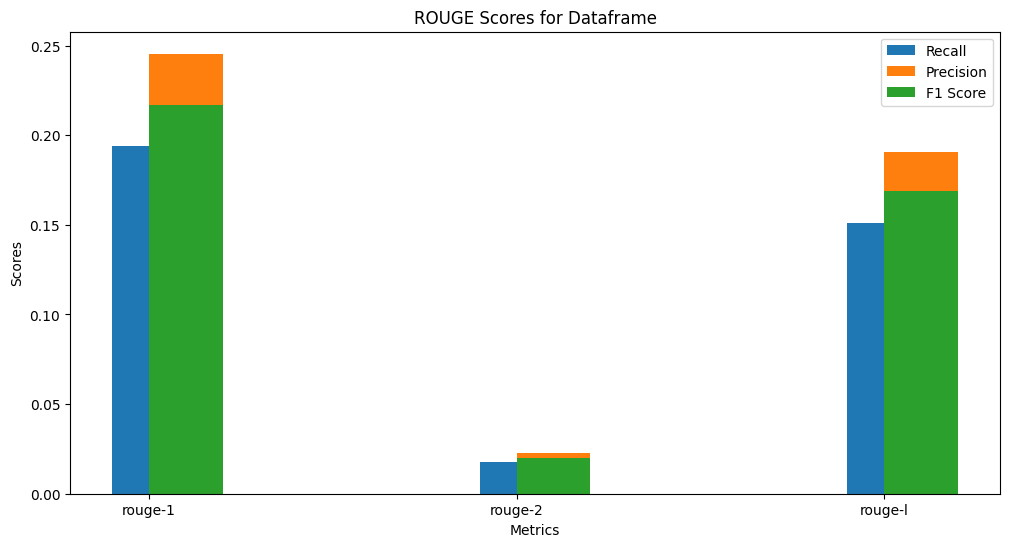

In [11]:
metrics = ['rouge-1', 'rouge-2', 'rouge-l']
recalls = [rouge_scores_df[0][metric]['r'] for metric in metrics]
precisions = [rouge_scores_df[0][metric]['p'] for metric in metrics]
f1_scores = [rouge_scores_df[0][metric]['f'] for metric in metrics]

x = range(len(metrics))
plt.figure(figsize=(12, 6))
plt.bar(x, recalls, width=0.2, label='Recall', align='center')
plt.bar(x, precisions, width=0.2, label='Precision', align='edge')
plt.bar(x, f1_scores, width=0.2, label='F1 Score', align='edge')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores for Dataframe')
plt.xticks(x, metrics)
plt.legend()
plt.show()

**5. Custom Summarization (by Word Frequency technique) of lecture trancript file using RDD**

In [12]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    return text.replace('SPEAKER 0', '').replace('SPEAKER 1', '').replace('UNKNOWN', '')

def custom_summarization_using_rdd(paragraph):
    word_freq = {}
    if len(paragraph) > 6000:
        paragraph = preprocess_text(paragraph)
        doc = nlp(paragraph)
        stop_words = set(STOP_WORDS).union(punctuation)

        for word in doc:
            word_text = word.text.lower()
            if word_text not in stop_words:
                word_freq[word_text] = word_freq.get(word_text, 0) + 1

        max_freq = max(word_freq.values(), default=1)
        word_freq_normalized = {word: freq / max_freq for word, freq in word_freq.items()}

        sent_tokens = [sent for sent in doc.sents if len(sent.text.split()) > 4]
        sent_score = {}
        for sent in sent_tokens:
            for word in sent:
                if word.text.lower() in word_freq_normalized:
                    sent_score[sent.text] = sent_score.get(sent.text, 0) + word_freq_normalized[word.text.lower()]

        summary = nlargest(n=5, iterable=sent_score, key=sent_score.get)
        final_summary_rdd = " ".join(summary)
        return (final_summary_rdd, word_freq)
    return (None, {})

file_path = "/content/MTHS4005 Lecture 3 - transcript.txt"
lines_rdd = spark.sparkContext.textFile(file_path)

text_rdd = lines_rdd.flatMap(lambda x: x.split('\n\n'))
summaries_and_freqs_rdd = text_rdd.map(custom_summarization_using_rdd).filter(lambda x: x[0] is not None)
combined_freqs = summaries_and_freqs_rdd.map(lambda x: x[1]).reduce(lambda a, b: {k: a.get(k, 0) + b.get(k, 0) for k in set(a) | set(b)})
final_summary_rdd = '\n\n'.join(summaries_and_freqs_rdd.map(lambda x: x[0]).collect())

summary_file_path_rdd = '/content/summary_rdd.txt'
heading = ('/content/MTHS4005 Lecture 3 - transcript').split('/')[-1] +' Summary' + '\n';

with open(summary_file_path_rdd, 'w') as f:
    f.write(heading)
    f.write(final_summary_rdd)


f"Summary file has been saved to: {summary_file_path_rdd}"

'Summary file has been saved to: /content/summary_rdd.txt'

Length of the generated summary using RDD

In [13]:
len(final_summary_rdd)

2535

**6. Word Frequency Distribution for Summary generated using RDDs**

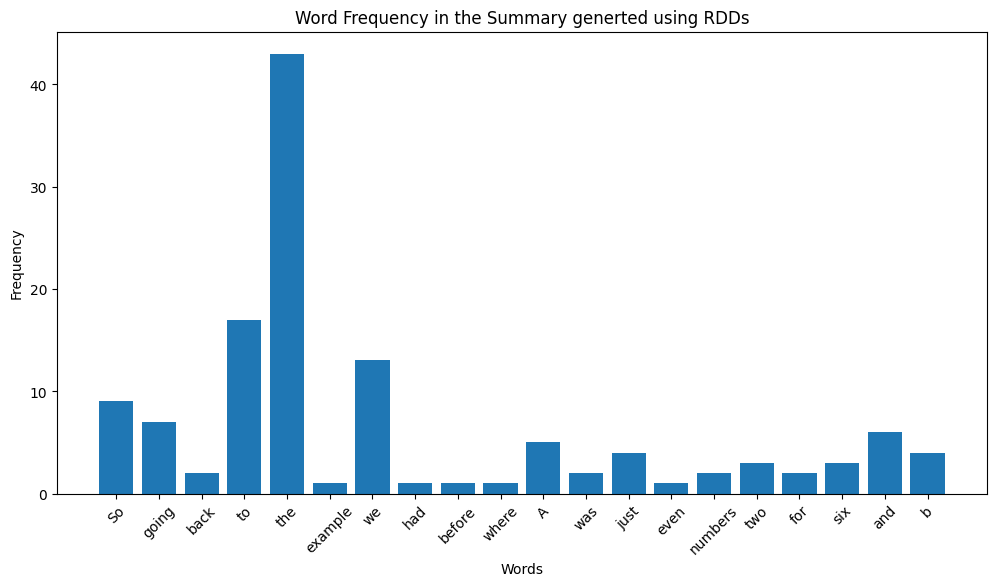

In [14]:
word_freq = {}
for word in final_summary_rdd.split():
    word_freq[word] = word_freq.get(word, 0) + 1
words, freqs = zip(*word_freq.items())

plt.figure(figsize=(12, 6))
plt.bar(words[:20], freqs[:20])
plt.xticks(rotation=45)
plt.title('Word Frequency in the Summary generted using RDDs')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

**7. Evaluating the accuracy using ROUGE metric for summary generated using RDDs**

In [15]:
def compute_rouge_scores(reference, generated):
    rouge = Rouge()
    rouge_scores_rdd = rouge.get_scores(generated, reference)
    return rouge_scores_rdd

reference_summary="This week's discussion focuses on probability, introducing the mathematical background to probability and discussing its axioms. The building blocks of probability include conditional probability, independence, and random variables. Sample space, often denoted by omega, is the set of all possible outcomes of a random experiment. Experiments can be experimental designs or observations in the real world, such as stock markets. An event is a set of outcomes to which we can assign a probability, and this can be done using simple examples like throwing a die or collecting two coins. For example, if a coin throws a head, there are four possible outcomes. If a coin tosses a coin until a head appears, there are infinitely many possibilities. In mathematics, we can count these outcomes, and we can easily enumerate them. Uncountable outcomes, such as the time until a volcano next erupts, can also be used to understand probability distributions. In this case, the state space sample space is the time until something occurs, which can be positive or uncountable. The speaker emphasizes the importance of considering what is important to us when looking at random variables, such as how many heads there are. The set of possible outcomes has to be finite, and the speaker uses examples of uncountable events to illustrate the concept of probability. In conclusion, this week's discussion focuses on probability, sample space, and probability distributions. By understanding the mathematical foundations of probability and the importance of considering individual outcomes, we can better understand the complexity of probability and its applications in various fields."

rouge_scores_rdd = compute_rouge_scores(reference_summary, final_summary_rdd)
print("ROUGE Scores:", rouge_scores_rdd)


ROUGE Scores: [{'rouge-1': {'r': 0.302158273381295, 'p': 0.2131979695431472, 'f': 0.24999999514898674}, 'rouge-2': {'r': 0.08520179372197309, 'p': 0.05121293800539083, 'f': 0.06397305928346347}, 'rouge-l': {'r': 0.2589928057553957, 'p': 0.18274111675126903, 'f': 0.21428570943470107}}]


**8. ROUGE Score Visualisation for summary generated using RDD**

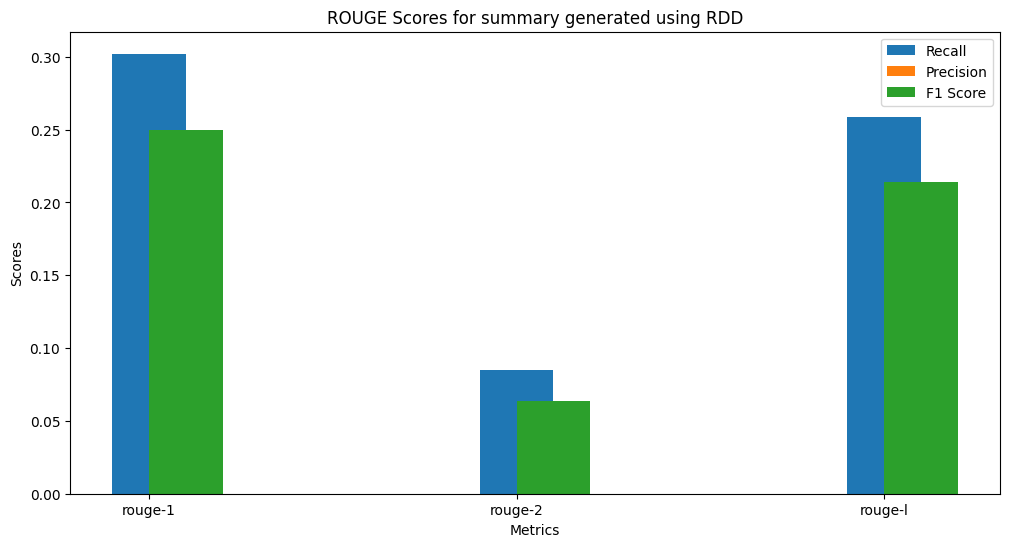

In [16]:
metrics = ['rouge-1', 'rouge-2', 'rouge-l']
recalls = [rouge_scores_rdd[0][metric]['r'] for metric in metrics]
precisions = [rouge_scores_rdd[0][metric]['p'] for metric in metrics]
f1_scores = [rouge_scores_rdd[0][metric]['f'] for metric in metrics]

x = range(len(metrics))
plt.figure(figsize=(12, 6))
plt.bar(x, recalls, width=0.2, label='Recall', align='center')
plt.bar(x, precisions, width=0.2, label='Precision', align='edge')
plt.bar(x, f1_scores, width=0.2, label='F1 Score', align='edge')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores for summary generated using RDD')
plt.xticks(x, metrics)
plt.legend()
plt.show()


**Comparison between DataFrame and RDD Summarization**



**9. Orginal Text length vs Summarized text length generated using Dataframes
and RDDs**

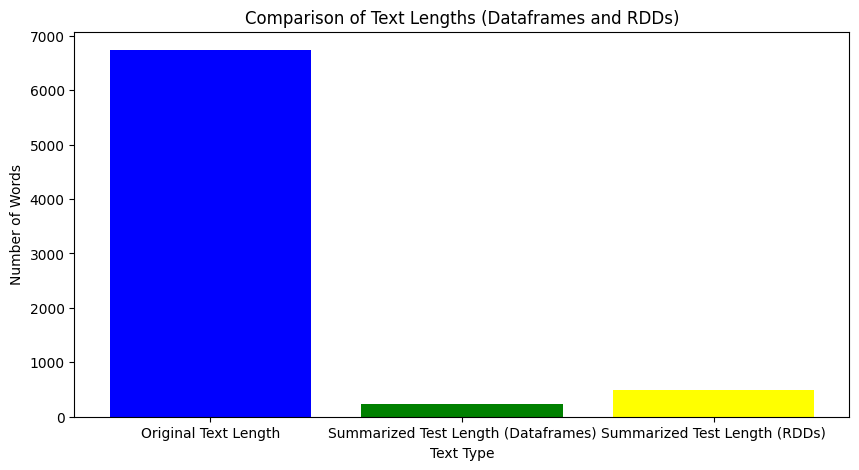

In [17]:
original_length = len(text.split())
summarized_length_df = len(final_summary_df.split())
summarized_length_rdd = len(final_summary_rdd.split())


plt.figure(figsize=(10, 5))
plt.bar(['Original Text Length', 'Summarized Test Length (Dataframes)', 'Summarized Test Length (RDDs)'], [original_length, summarized_length_df, summarized_length_rdd], color=['blue', 'green', 'yellow'])
plt.title('Comparison of Text Lengths (Dataframes and RDDs)')
plt.xlabel('Text Type')
plt.ylabel('Number of Words')
plt.show()

**10. Comparison of ROUGE Scores between DataFrame and RDD Summarization**


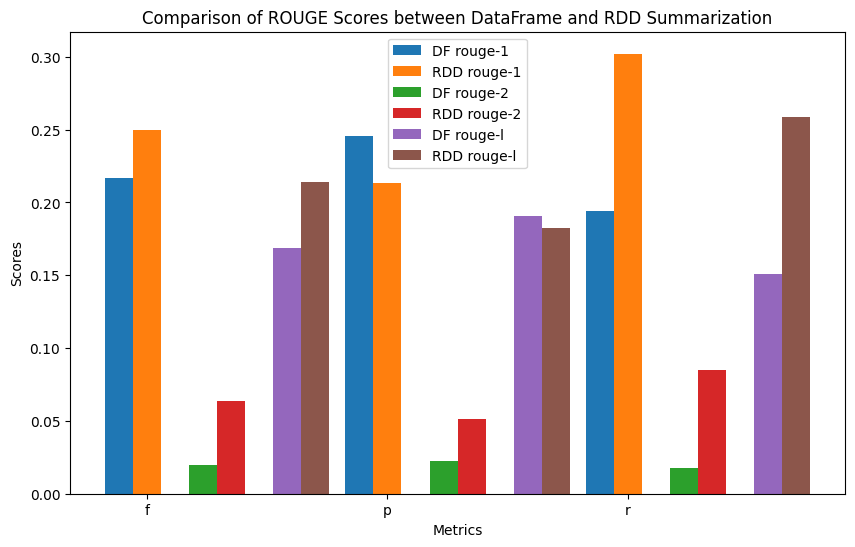

In [18]:
scores_df = rouge_scores_df[0]
scores_rdd = rouge_scores_rdd[0]

rouge_types = ['rouge-1', 'rouge-2', 'rouge-l']
metrics = ['f', 'p', 'r']

scores_df = np.array([[scores_df[rouge][metric] for metric in metrics] for rouge in rouge_types])
scores_rdd = np.array([[scores_rdd[rouge][metric] for metric in metrics] for rouge in rouge_types])

bar_width = 0.35
index = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
for i, rouge_type in enumerate(rouge_types):
    offsets = (np.arange(len(metrics)) - bar_width / 2. + i * bar_width)
    ax.bar(offsets, scores_df[i], bar_width / len(rouge_types), label=f'DF {rouge_type}')
    ax.bar(offsets + bar_width / len(rouge_types), scores_rdd[i], bar_width / len(rouge_types), label=f'RDD {rouge_type}')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of ROUGE Scores between DataFrame and RDD Summarization')
ax.set_xticks(index + bar_width / len(rouge_types) - bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


**11. Custom summarization using Named Entity Recognition (NER) technique**


In [24]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    """Remove speaker labels and other unwanted placeholders."""
    return text.replace('SPEAKER 0', '').replace('SPEAKER 1', '').replace('UNKNOWN', '')

def custom_summarization(paragraph):
    """Perform summarization using word frequency, emphasizing named entities."""
    if len(paragraph) > 6000:  # Filter out short paragraphs
        paragraph = preprocess_text(paragraph)
        doc = nlp(paragraph)

        word_freq = {}
        entity_weights = 1.5  # Increase the weight for named entities
        stop_words = set(STOP_WORDS).union(punctuation)

        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE', 'LOC']:  # Focus on specific entity types
                ent_text = ent.text.lower()
                if ent_text not in stop_words:
                    word_freq[ent_text] = word_freq.get(ent_text, 0) + (1 * entity_weights)

        for word in doc:
            word_text = word.text.lower()
            if word_text not in stop_words and word_text not in word_freq:
                word_freq[word_text] = word_freq.get(word_text, 0) + 1

        max_freq = max(word_freq.values(), default=1)
        word_freq_normalized = {word: freq / max_freq for word, freq in word_freq.items()}

        sent_tokens = [sent for sent in doc.sents if len(sent.text.split()) > 4]
        sent_score = {}
        for sent in sent_tokens:
            for word in sent:
                word_text = word.text.lower()
                if word_text in word_freq_normalized:
                    sent_score[sent.text] = sent_score.get(sent.text, 0) + word_freq_normalized[word_text]

        summary = nlargest(n=5, iterable=sent_score
        , key=sent_score.get)
        final_summary = " ".join(summary)
        return final_summary
file_path = '/content/MTHS4005 Lecture 3 - transcript.txt'
text_df = spark.read.text(file_path)

text_values = [row.value for row in text_df.collect()]
text = ' '.join(text_values)
final_summary_ner = custom_summarization_using_dataframe(text)


summary_file_path_df = '/content/summary_rdd_ner.txt'
heading = ('/content/MTHS4005 Lecture 3 - transcript').split('/')[-1] + ' Summary' + '\n';

# Write summary with heading to a file
with open(summary_file_path_df, 'w') as f:
    f.write(heading)
    f.write(final_summary_ner)

f"Summary file has been saved to: {summary_file_path_df}"


'Summary file has been saved to: /content/summary_rdd_ner.txt'

**12. Evaluating the accuracy using ROUGE metric for summary generated using NER technique**

In [21]:
def compute_rouge_scores(reference, generated):
    rouge = Rouge()
    rouge_scores_rdd_ner = rouge.get_scores(generated, reference)
    return rouge_scores_rdd_ner

reference_summary="This week's discussion focuses on probability, introducing the mathematical background to probability and discussing its axioms. The building blocks of probability include conditional probability, independence, and random variables. Sample space, often denoted by omega, is the set of all possible outcomes of a random experiment. Experiments can be experimental designs or observations in the real world, such as stock markets. An event is a set of outcomes to which we can assign a probability, and this can be done using simple examples like throwing a die or collecting two coins. For example, if a coin throws a head, there are four possible outcomes. If a coin tosses a coin until a head appears, there are infinitely many possibilities. In mathematics, we can count these outcomes, and we can easily enumerate them. Uncountable outcomes, such as the time until a volcano next erupts, can also be used to understand probability distributions. In this case, the state space sample space is the time until something occurs, which can be positive or uncountable. The speaker emphasizes the importance of considering what is important to us when looking at random variables, such as how many heads there are. The set of possible outcomes has to be finite, and the speaker uses examples of uncountable events to illustrate the concept of probability. In conclusion, this week's discussion focuses on probability, sample space, and probability distributions. By understanding the mathematical foundations of probability and the importance of considering individual outcomes, we can better understand the complexity of probability and its applications in various fields."

rouge_scores_rdd_ner = compute_rouge_scores(reference_summary, final_summary_ner)
print("ROUGE Scores:", rouge_scores_rdd_ner)

ROUGE Scores: [{'rouge-1': {'r': 0.19424460431654678, 'p': 0.24545454545454545, 'f': 0.21686746494733966}, 'rouge-2': {'r': 0.017937219730941704, 'p': 0.022727272727272728, 'f': 0.020050120382662122}, 'rouge-l': {'r': 0.1510791366906475, 'p': 0.19090909090909092, 'f': 0.16867469386300235}}]


**13. Comparison of ROUGE Scores of custom summarization generated using RDD by Word Frequency technique and RDD by NER technique**

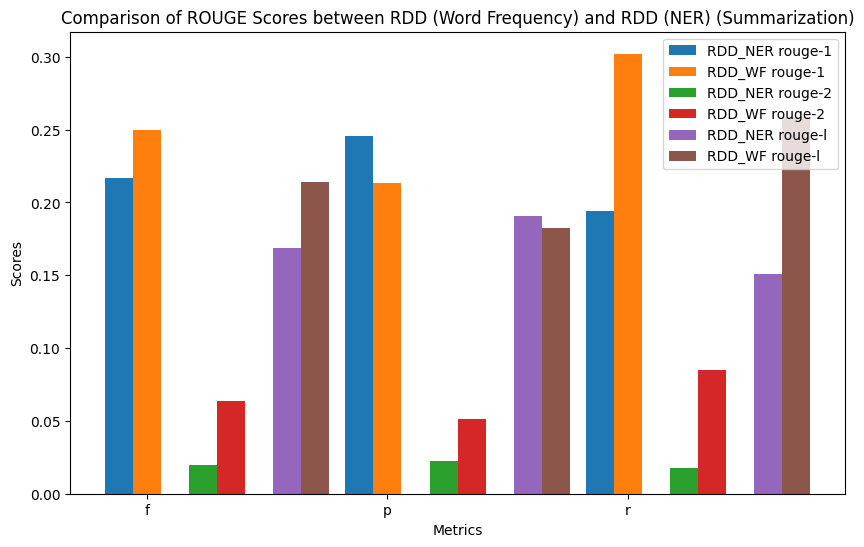

In [23]:
scores_rdd_ner = rouge_scores_rdd_ner[0]
scores_rdd = rouge_scores_rdd[0]

rouge_types = ['rouge-1', 'rouge-2', 'rouge-l']
metrics = ['f', 'p', 'r']

scores_df = np.array([[scores_rdd_ner[rouge][metric] for metric in metrics] for rouge in rouge_types])
scores_rdd = np.array([[scores_rdd[rouge][metric] for metric in metrics] for rouge in rouge_types])

bar_width = 0.35
index = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
for i, rouge_type in enumerate(rouge_types):
    offsets = (np.arange(len(metrics)) - bar_width / 2. + i * bar_width)
    ax.bar(offsets, scores_df[i], bar_width / len(rouge_types), label=f'RDD_NER {rouge_type}')
    ax.bar(offsets + bar_width / len(rouge_types), scores_rdd[i], bar_width / len(rouge_types), label=f'RDD_WF {rouge_type}')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of ROUGE Scores between RDD (Word Frequency) and RDD (NER) (Summarization)')
ax.set_xticks(index + bar_width / len(rouge_types) - bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

**Comparsion of the summary file fize generated using Dataframes and RDDs**

In [26]:
def get_file_size(file_path):
    bytes_size = os.path.getsize(file_path)
    kilobytes_size = bytes_size / 1024
    return kilobytes_size

# File paths
file_paths = ["/content/MTHS4005 Lecture 3 - transcript.txt", "/content/summary_dataframe.txt", "/content/summary_rdd.txt", "/content/summary_rdd_ner.txt"]

# Loop through each file path and calculate the size
for file_path in file_paths:
    file_size = get_file_size(file_path)
    print(f"The size of the file '{file_path}' is {file_size:.2f} KB.")

The size of the file '/content/MTHS4005 Lecture 3 - transcript.txt' is 34.25 KB.
The size of the file '/content/summary_dataframe.txt' is 1.27 KB.
The size of the file '/content/summary_rdd.txt' is 2.51 KB.
The size of the file '/content/summary_rdd_ner.txt' is 1.27 KB.
